In [1]:
import geopandas as gpd
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
import numpy as np
import os
import palettable
from lonboard import viz, Map, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap
import rioxarray
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import xarray as xr

IMPORTANT for lonboard: need to pip install anywidget==0.9.4 in the base environment from which Jupyter launches (and the working environment if necessary) each time the workspace restarts. Refresh browser. 

In [2]:
modis = pd.read_csv('/projects/shared-buckets/coffield/modis/outputs/amazon/2016_03_detections_Terra_masked_filter.csv')
modis = gpd.GeoDataFrame(modis, geometry=gpd.points_from_xy(modis.longitude, modis.latitude), crs="EPSG:4326")
modis.acq_datetime = pd.to_datetime(modis.acq_datetime)

#modis = modis[(modis.daynight=='N') | (modis.fire_mask > 6)] #not daytime potential fires
modis = modis[(modis.pass_filter==True) | (modis.fire_mask>6)] #only pixels that passed space/time filter
modis.head()

,longitude,latitude,fire_mask,daynight,confidence,acq_date,acq_time,acq_datetime,j,geometry,forest,pass_filter
4,-58.650900,-16.247719,5,D,x,2016/03/31,1420,2016-03-31 14:20:00+00:00,841,POINT (-58.65090 -16.24772),1,True
8,-58.649555,-16.238443,5,D,x,2016/03/31,1420,2016-03-31 14:20:00+00:00,841,POINT (-58.64955 -16.23844),1,True
9,-57.632893,-15.513246,8,D,n,2016/03/13,1430,2016-03-13 14:30:00+00:00,1150,POINT (-57.63289 -15.51325),1,NaN
10,-57.635265,-15.507513,8,D,n,2016/03/08,1415,2016-03-08 14:15:00+00:00,772,POINT (-57.63526 -15.50751),1,NaN
11,-57.637814,-15.506916,8,D,n,2016/03/13,1430,2016-03-13 14:30:00+00:00,1150,POINT (-57.63781 -15.50692),1,NaN


In [4]:
#test lonboard
viz(modis)

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

In [3]:
viirs = pd.read_csv('/projects/shared-buckets/coffield/viirs/outputs/amazon/2016_03_detections_SNPP_masked_filter.csv')

viirs = gpd.GeoDataFrame(viirs, geometry=gpd.points_from_xy(viirs.longitude, viirs.latitude), crs="EPSG:4326")
viirs.acq_datetime = pd.to_datetime(viirs.acq_datetime)
viirs.acq_date = viirs.acq_datetime.dt.strftime('%Y/%m/%d')
   
viirs = viirs[(viirs.pass_filter==True) | (viirs.fire_mask>6)] #only pixels that passed space/time filter

In [6]:
#add columnn for view zenith angle using pixel size lookup table
pix_lut = pd.read_csv('/projects/shared-buckets/coffield/pix_size_lut.csv', index_col='sample')
viirs['vza'] = pix_lut.loc[viirs['j'], 'scan_angle'].values
viirs

,longitude,latitude,fire_mask,daynight,confidence,acq_date,acq_time,acq_datetime,j,geometry,forest,pass_filter,vza
92,-60.357710,-18.136751,8.0,N,n,2016/03/19,454,2016-03-19 04:54:00+00:00,2010.0,POINT (-60.35771 -18.13675),1,NaN,31.693800
93,-60.381844,-18.125023,5.0,D,x,2016/03/16,1818,2016-03-16 18:18:00+00:00,650.0,POINT (-60.38184 -18.12502),1,True,50.279700
94,-60.381905,-18.123245,5.0,D,x,2016/03/16,1818,2016-03-16 18:18:00+00:00,652.0,POINT (-60.38191 -18.12325),1,True,50.261900
95,-60.138130,-17.406937,8.0,D,n,2016/03/29,1736,2016-03-29 17:36:00+00:00,3085.0,POINT (-60.13813 -17.40694),1,NaN,3.068000
97,-60.327454,-17.676804,8.0,D,n,2016/03/18,1742,2016-03-18 17:42:00+00:00,2741.0,POINT (-60.32745 -17.67680),1,NaN,12.245300
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58524,-67.291214,6.295879,5.0,D,x,2016/03/25,1718,2016-03-25 17:18:00+00:00,5027.0,POINT (-67.29121 6.29588),1,True,43.041000
58525,-67.297386,6.299789,8.0,D,n,2016/03/25,1718,2016-03-25 17:18:00+00:00,5028.0,POINT (-67.29739 6.29979),1,NaN,43.058800
58526,-67.288880,6.298247,5.0,D,x,2016/03/25,1718,2016-03-25 17:18:00+00:00,5028.0,POINT (-67.28888 6.29825),1,True,43.058800
58527,-67.292076,6.300704,8.0,D,n,2016/03/25,1718,2016-03-25 17:18:00+00:00,5027.0,POINT (-67.29208 6.30070),1,NaN,43.041000


In [7]:
v_cands = viirs[viirs.fire_mask<7]
v_known = viirs[viirs.fire_mask>6]
m_cands = modis[modis.fire_mask<7]
m_known = modis[modis.fire_mask>6]

min_bound = viirs.acq_datetime.min()
max_bound = viirs.acq_datetime.max()
normalized_vknown = (v_known.acq_datetime - min_bound) / (max_bound - min_bound)
normalized_vcands = (v_cands.acq_datetime - min_bound) / (max_bound - min_bound)

normalized_mknown = (m_known.acq_datetime - min_bound) / (max_bound - min_bound)
normalized_mcands = (m_cands.acq_datetime - min_bound) / (max_bound - min_bound)

In [8]:
#pick a colormap
cmap = palettable.colorbrewer.diverging.BrBG_10
cmap = palettable.mycarta.Cube1_20
cmap = palettable.colorbrewer.sequential.Reds_7#Blues_7#Reds_7
cmap = palettable.colorbrewer.diverging.Spectral_8_r

#layer1 (bottom): modis candidates
layer1 = ScatterplotLayer.from_geopandas(m_cands)
layer1.get_fill_color = apply_continuous_cmap(normalized_mcands, cmap, alpha=0.9)
layer1.get_radius = 500
layer1.radius_units = "meters"
layer1.radius_min_pixels = 4

#layer2: modis known
layer2 = ScatterplotLayer.from_geopandas(m_known, stroked=True)
layer2.get_fill_color = apply_continuous_cmap(normalized_mknown, cmap, alpha=0.9)
layer2.get_radius = 450
layer2.get_line_width = 100
layer2.radius_units = "meters"
layer2.radius_min_pixels = 4

#layer3: viirs candidates
layer3 = ScatterplotLayer.from_geopandas(v_cands)
layer3.get_fill_color = apply_continuous_cmap(normalized_vcands, cmap, alpha=0.9)
layer3.get_radius = 200
layer3.radius_units = "meters"
layer3.radius_min_pixels = 2

#layer4: viirs known
layer4 = ScatterplotLayer.from_geopandas(v_known, stroked=True)
layer4.get_fill_color = apply_continuous_cmap(normalized_vknown, cmap, alpha=0.9)
layer4.get_radius = 150
layer4.get_line_width = 100
layer4.radius_units = "meters"
layer4.radius_min_pixels = 2

m = Map([layer1, layer2, layer3, layer4], _height=800)
#m.set_view_state(longitude':-60,'latitude':2,'zoom':7)
m

Map(layers=[ScatterplotLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7f6a3732f040>
[
  [
  …

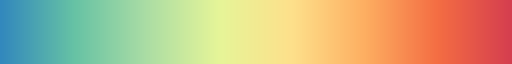

In [25]:
cmap.mpl_colormap

In [55]:
len(modis)

42645

In [56]:
len(m_cands)

34698

In [57]:
len(m_cands[m_cands.daynight=='N'])

1813

In [60]:
1813/34698

0.0522508501930947

In [59]:
len(m_cands) / len(modis)

0.8136475553992262

In [49]:
#timeseries

start = dt.date(2015,11,1)

days = [start + dt.timedelta(i) for i in range(30)]
days

[datetime.date(2015, 11, 1),
 datetime.date(2015, 11, 2),
 datetime.date(2015, 11, 3),
 datetime.date(2015, 11, 4),
 datetime.date(2015, 11, 5),
 datetime.date(2015, 11, 6),
 datetime.date(2015, 11, 7),
 datetime.date(2015, 11, 8),
 datetime.date(2015, 11, 9),
 datetime.date(2015, 11, 10),
 datetime.date(2015, 11, 11),
 datetime.date(2015, 11, 12),
 datetime.date(2015, 11, 13),
 datetime.date(2015, 11, 14),
 datetime.date(2015, 11, 15),
 datetime.date(2015, 11, 16),
 datetime.date(2015, 11, 17),
 datetime.date(2015, 11, 18),
 datetime.date(2015, 11, 19),
 datetime.date(2015, 11, 20),
 datetime.date(2015, 11, 21),
 datetime.date(2015, 11, 22),
 datetime.date(2015, 11, 23),
 datetime.date(2015, 11, 24),
 datetime.date(2015, 11, 25),
 datetime.date(2015, 11, 26),
 datetime.date(2015, 11, 27),
 datetime.date(2015, 11, 28),
 datetime.date(2015, 11, 29),
 datetime.date(2015, 11, 30)]

In [31]:
modis.day = modis.acq_datetime.dt.date

/projects/myenvs/hls/lib/python3.12/site-packages/geopandas/geodataframe.py:206: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)


(array([16740., 16744., 16748., 16752., 16756., 16760., 16764., 16768.,
        16770.]),
 [Text(16740.0, 0, '2015-11-01'),
  Text(16744.0, 0, '2015-11-05'),
  Text(16748.0, 0, '2015-11-09'),
  Text(16752.0, 0, '2015-11-13'),
  Text(16756.0, 0, '2015-11-17'),
  Text(16760.0, 0, '2015-11-21'),
  Text(16764.0, 0, '2015-11-25'),
  Text(16768.0, 0, '2015-11-29'),
  Text(16770.0, 0, '2015-12-01')])

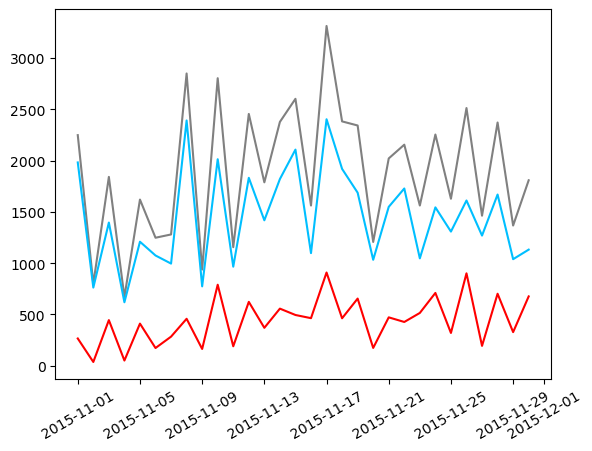

In [38]:
total = []
knowns = []
cands = []

for d in days:
    total.append(len(modis[modis.day==d]))
    knowns.append(len(modis[(modis.day==d) & (modis.fire_mask>6)]))
    cands.append(len(modis[(modis.day==d) & (modis.fire_mask<7)]))
plt.plot(days, total, c='gray')
plt.plot(days, knowns, c='red')
plt.plot(days, cands, c='deepskyblue')
plt.xticks(rotation=30)

In [50]:
viirs.day = viirs.acq_datetime.dt.date

/projects/myenvs/hls/lib/python3.12/site-packages/geopandas/geodataframe.py:206: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)


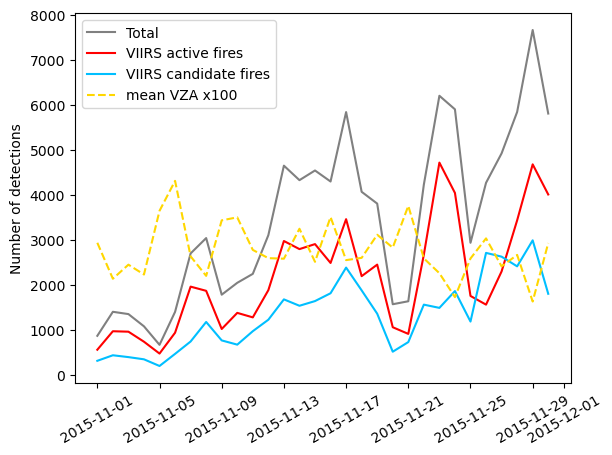

In [56]:
total = []
knowns = []
cands = []
vza = []

for d in days:
    subset = viirs[viirs.day==d]
    total.append(len(subset))
    knowns.append(len(subset[subset.fire_mask>6]))
    cands.append(len(subset[subset.fire_mask<7]))
    vza.append(subset.vza.mean())
plt.plot(days, total, c='gray', label='Total')
plt.plot(days, knowns, c='red', label='VIIRS active fires')
plt.plot(days, cands, c='deepskyblue', label='VIIRS candidate fires')
plt.plot(days, [v*100 for v in vza], c='gold', linestyle='--', label='mean VZA x100')
plt.xticks(rotation=30)
plt.ylabel('Number of detections')
plt.legend()

In [21]:
len(v_cands) / len(v_known)

0.2707568971267928